In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

plt.style.use("default")

warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [2]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [9]:
### Your code is here

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=[object]).columns.tolist()
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [11]:
df.shape

(131662, 29)

<Axes: >

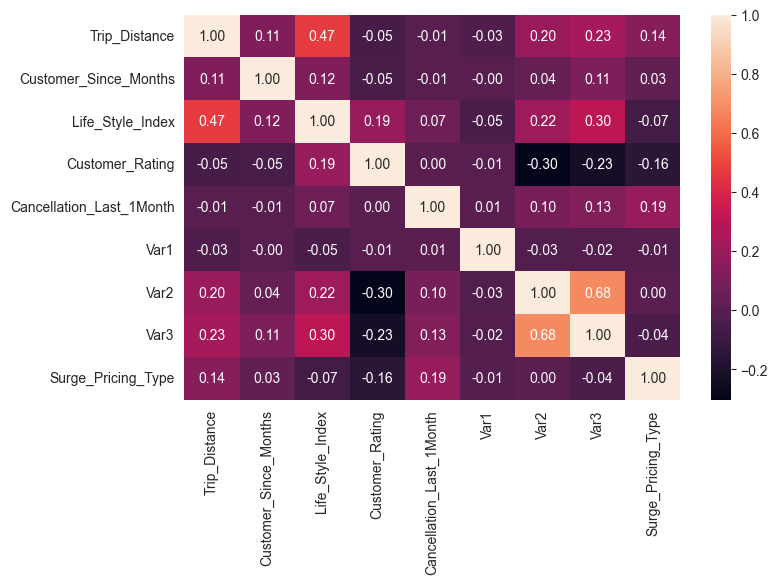

In [17]:
corrs = df[num_cols].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corrs, annot=True, fmt=".2f")


In [18]:
corrs = corrs.abs().unstack()
corrs = corrs[corrs.index.get_level_values(0) != corrs.index.get_level_values(1)].sort_values(ascending=False)[::2]

In [19]:
corrs.head(5)

Var2              Var3                0.683437
Trip_Distance     Life_Style_Index    0.468332
Life_Style_Index  Var3                0.303324
Var2              Customer_Rating     0.302968
Trip_Distance     Var3                0.231706
dtype: float64

### Training

In [22]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X = df.drop('Surge_Pricing_Type', axis=1)
Y = df['Surge_Pricing_Type']

In [23]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y,
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [24]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

### Your code is here

pipe = Pipeline([("scaler", StandardScaler()),
                 ("one_vs_all", OneVsRestClassifier(LogisticRegression()))])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [32]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



    Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации!

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [33]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [38]:
### Your code is here
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_all',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1],
                         'one_vs_all__estimator__penalty': ['l1', 'l2',
                                                            'elasticnet']},
             scoring='accuracy')

In [41]:
pipe.set_params(**search.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [76]:
### Your code is here

pipe.fit(X_train, Y_train)
print(classification_report(Y_test, pipe.predict(X_test), digits=3))


              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



    Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор?

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

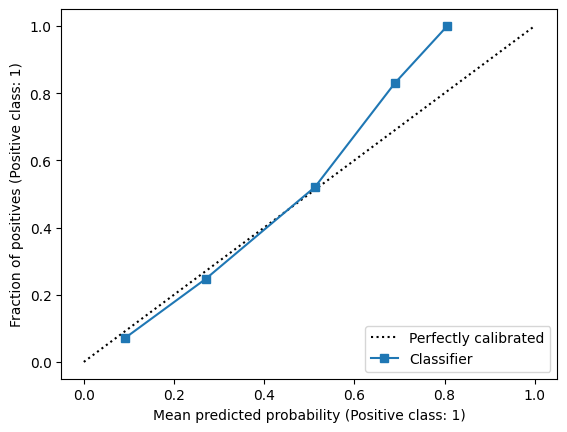

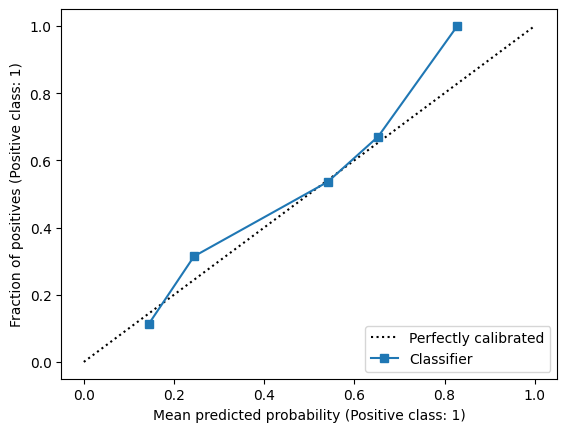

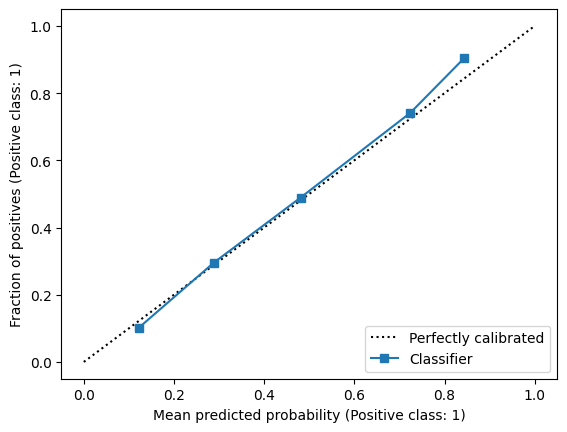

In [47]:
from sklearn.calibration import CalibrationDisplay

for i in range(3):
    CalibrationDisplay.from_predictions((Y_test == i + 1).astype(float),
                                        pipe.predict_proba(X_test)[:, i])

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [67]:
### Создание полиномиальных признаков
### Your code is here

X_polynomial = X.copy()

num_cols = X_polynomial.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols:
    for power in range(2, 5):
        X_polynomial[f"{col}^{power}"] = X_polynomial[col] ** power


In [68]:
X_polynomial.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Cancellation_Last_1Month^4,Var1^2,Var1^3,Var1^4,Var2^2,Var2^3,Var2^4,Var3^2,Var3^3,Var3^4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,True,False,...,0,1600.0,64000.0,2560000.0,2116,97336,4477456,3600,216000,12960000
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,True,False,...,0,1444.0,54872.0,2085136.0,3136,175616,9834496,6084,474552,37015056
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,True,False,...,16,3721.0,226981.0,13845841.0,3136,175616,9834496,5929,456533,35153041
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,False,True,...,0,3721.0,226981.0,13845841.0,2704,140608,7311616,5476,405224,29986576
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,False,True,...,256,2601.0,132651.0,6765201.0,2401,117649,5764801,10404,1061208,108243216


In [69]:
X_pol_train, X_pol_test, Y_train, Y_test  = train_test_split(X_polynomial, Y,
                                                             test_size=0.2,
                                                             shuffle=True,
                                                             random_state=2022)

In [80]:
pipe.set_params(**search.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [81]:
### Your code is here
pipe.fit(X_pol_train, Y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [82]:
print(classification_report(Y_test, pipe.predict(X_pol_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

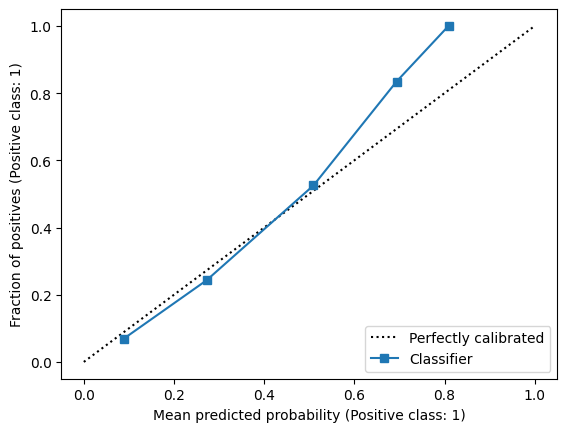

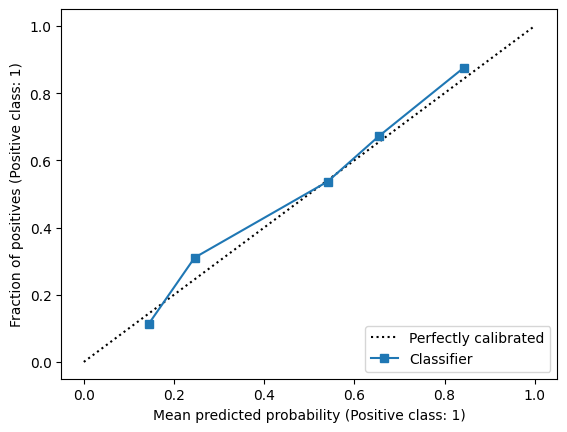

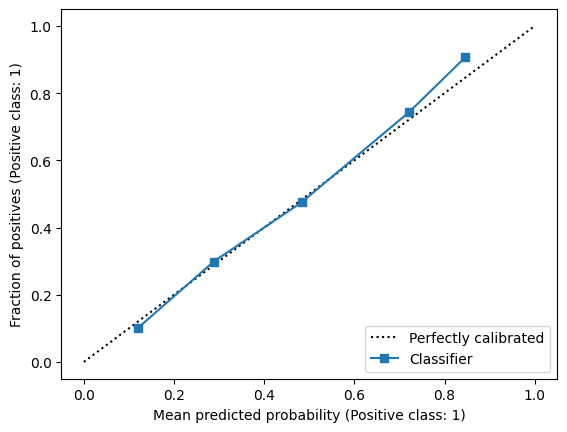

In [83]:
### Your code is here

for i in range(3):
    CalibrationDisplay.from_predictions((Y_test == i + 1).astype(float),
                                        pipe.predict_proba(X_pol_test)[:, i])

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [84]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y,
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [107]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here

pipe = Pipeline([("scaler", StandardScaler()),
                 ("one_vs_one", OneVsOneClassifier(SGDClassifier(loss="hinge")))])
pipe.fit(X_train, Y_train)
print(classification_report(Y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.732     0.533     0.617      5372
           2      0.625     0.875     0.729     11349
           3      0.766     0.522     0.621      9612

    accuracy                          0.676     26333
   macro avg      0.708     0.643     0.656     26333
weighted avg      0.698     0.676     0.667     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [109]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [110]:
### Your code is here

search = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy")
search.fit(X_train, Y_train)

pipe.set_params(**search.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_one',
                 OneVsOneClassifier(estimator=SGDClassifier(alpha=0.01)))])

In [111]:
pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_one',
                 OneVsOneClassifier(estimator=SGDClassifier(alpha=0.01)))])

In [112]:
print(classification_report(Y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.744     0.529     0.618      5372
           2      0.625     0.876     0.730     11349
           3      0.768     0.527     0.625      9612

    accuracy                          0.678     26333
   macro avg      0.712     0.644     0.658     26333
weighted avg      0.702     0.678     0.669     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?